# Traditional Classifier: Training & Evaluation Notebook


In [1]:
import yaml
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
from importlib import resources as impresources

In [2]:
from recurrent_health_events_prediction.utils.general_utils import check_if_file_exists

random_state = 42  # Set random state for reproducibility
model_config_path = "/workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/classifier_baselines/config.yaml"
model_config_exists = check_if_file_exists(model_config_path)
plot_shap = True  # Whether to plot SHAP values
if not model_config_exists:
    raise FileNotFoundError(f"Model config file not found: {model_config_path}")

In [3]:
models_to_train = [
    "logistic_regression",
    "random_forest",
    # "lgbm",
]

In [4]:
from recurrent_health_events_prediction import configs

# Load high-level data and model configs
data_config_path = (impresources.files(configs) / "data_config.yaml")

with open(data_config_path) as f:
    data_config = yaml.safe_load(f)

with open(model_config_path) as f:
    model_config = yaml.safe_load(f)

training_data_config = data_config['training_data']["mimic"]
train_test_data_dir = training_data_config["data_directory"]

print(f"Train/test data directory: {train_test_data_dir}")

target_col = training_data_config["binary_event_col"]
event_id_col = training_data_config["hosp_id_col"]
class_names = training_data_config.get("class_names", None)
features_to_scale = training_data_config.get('features_to_scale', None)
missing_features = model_config.get('missing_features', None)
next_admt_type_col = training_data_config.get("next_admt_type_col", None)

print(f"Target column: {target_col}")
print(f"Event ID column: {event_id_col}")
print(f"Features to scale: {features_to_scale}")
print(f"Missing features: {missing_features}")
print(f"Next admission type column: {next_admt_type_col}")

class_names_dict = {i: class_names[i] for i in range(len(class_names))} if class_names else None


Train/test data directory: /workspaces/msc-thesis-recurrent-health-modeling/data/mimic-iii-preprocessed/copd_hf_renal_diabetes/multiple_hosp_patients/train_test
Target column: READMISSION_30_DAYS
Event ID column: HADM_ID
Features to scale: ['AGE', 'LOG_HOSPITALIZATION_DAYS', 'LOG_DAYS_IN_ICU', 'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION', 'LOG_PARTICIPATION_DAYS', 'LOG_NUM_DRUGS', 'NUM_PROCEDURES', 'CHARLSON_INDEX', 'NUM_PREV_HOSPITALIZATIONS', 'NUM_COMORBIDITIES', 'PARTICIPATION_DAYS']
Missing features: {'READM_30_DAYS_PAST_MEAN': 'median', 'READM_30_DAYS_PAST_SUM': 'median', 'LOG_DAYS_SINCE_LAST_HOSPITALIZATION': 'median', 'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN': 'median', 'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD': 'median'}
Next admission type column: NEXT_ADMISSION_TYPE


In [5]:
# Load & filter data
train_data_filepath = os.path.join(train_test_data_dir, "train_events.csv")
test_data_filepath = os.path.join(train_test_data_dir, "test_events.csv")
train_df = pd.read_csv(train_data_filepath)
if next_admt_type_col is not None:
    train_df = train_df[(train_df["IS_LAST_EVENT"] == 1) & (train_df[next_admt_type_col] != "ELECTIVE")]
test_df = pd.read_csv(test_data_filepath)
if next_admt_type_col is not None:
    test_df = test_df[(test_df["IS_LAST_EVENT"] == 1) & (test_df[next_admt_type_col] != "ELECTIVE")]

output_dir = os.path.dirname(model_config_path)
print(f"Output directory: {output_dir}")

base_features_cols: list[str] = (
    model_config["current_feat_cols"] + model_config["past_summary_feat_cols"]
)

Output directory: /workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/classifier_baselines


In [6]:
train_df[base_features_cols].head()

,AGE,CHARLSON_INDEX,NUM_PREV_HOSPITALIZATIONS,NUM_PROCEDURES,LOG_DAYS_IN_ICU,NUM_DRUGS,LOG_PARTICIPATION_DAYS,HAS_DIABETES,HAS_COPD,HAS_CONGESTIVE_HF,...,ETHNICITY_WHITE,ETHNICITY_BLACK,ETHNICITY_HISPANIC,INSURANCE_MEDICAID,INSURANCE_PRIVATE,LOG_DAYS_SINCE_LAST_HOSPITALIZATION,READM_30_DAYS_PAST_MEAN,READM_30_DAYS_PAST_SUM,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD
2,75,7,2,12,0.848527,42,7.499977,False,True,False,...,True,False,False,False,False,7.127073,0.000000,0.0,6.690951,0.616770
8,69,8,3,2,1.598183,22,7.502738,False,False,False,...,True,False,False,False,False,1.545196,0.333333,1.0,6.164666,3.003528
10,54,2,1,2,0.848175,18,5.468060,False,False,False,...,False,False,False,False,True,5.410802,0.000000,0.0,5.410802,NaN
12,80,12,1,4,1.918345,40,7.541683,True,True,True,...,True,False,False,False,False,7.528989,0.000000,0.0,7.528989,NaN
15,84,7,2,3,2.153851,49,7.835579,False,True,False,...,True,False,False,False,False,7.257424,0.000000,0.0,7.123560,0.189312


In [7]:
print("Training traditional classifier...")
print("Using base features: ", base_features_cols)
print("Target column: ", target_col)
print("Random state: ", random_state)

Training traditional classifier...
Using base features:  ['AGE', 'CHARLSON_INDEX', 'NUM_PREV_HOSPITALIZATIONS', 'NUM_PROCEDURES', 'LOG_DAYS_IN_ICU', 'NUM_DRUGS', 'LOG_PARTICIPATION_DAYS', 'HAS_DIABETES', 'HAS_COPD', 'HAS_CONGESTIVE_HF', 'DISCHARGE_LOCATION_POST_ACUTE_CARE', 'GENDER_M', 'ADMISSION_TYPE_ELECTIVE', 'ETHNICITY_WHITE', 'ETHNICITY_BLACK', 'ETHNICITY_HISPANIC', 'INSURANCE_MEDICAID', 'INSURANCE_PRIVATE', 'LOG_DAYS_SINCE_LAST_HOSPITALIZATION', 'READM_30_DAYS_PAST_MEAN', 'READM_30_DAYS_PAST_SUM', 'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN', 'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD']
Target column:  READMISSION_30_DAYS
Random state:  42


### Prepare Data for Train & Test

In [8]:

# Add a random feature for reference
from recurrent_health_events_prediction.training.utils_traditional_classifier import impute_missing_features, scale_features


np.random.seed(random_state)  # Ensure reproducibility
train_df["RANDOM_FEATURE"] = np.random.rand(len(train_df))
test_df["RANDOM_FEATURE"] = np.random.rand(len(test_df))

feature_cols = base_features_cols + ["RANDOM_FEATURE"]

# Split matrices
X_train = train_df[feature_cols]
y_train = train_df[target_col].astype(int)

X_test = test_df[feature_cols]
y_test = test_df[target_col].astype(int)
test_ids = test_df[event_id_col]

# Impute optional missing features
if missing_features:
    X_train, X_test = impute_missing_features(X_train, X_test, missing_features)

features_to_scale = features_to_scale + ["RANDOM_FEATURE"] if features_to_scale is not None else None

# Scale selected features (if provided)
X_train_scaled, X_test_scaled = scale_features(
    X_train, X_test, features_to_scale=features_to_scale
)

print("Class distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nClass distribution in test set:")
print(pd.Series(y_test).value_counts(normalize=True))

No 'NA' found in feature 'READM_30_DAYS_PAST_MEAN'. No imputation needed.
No 'NA' found in feature 'READM_30_DAYS_PAST_SUM'. No imputation needed.
No 'NA' found in feature 'LOG_DAYS_SINCE_LAST_HOSPITALIZATION'. No imputation needed.
No 'NA' found in feature 'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN'. No imputation needed.
'NA' found in feature 'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD'. Filling with strategy 'median'.
Scaling features: ['AGE', 'CHARLSON_INDEX', 'NUM_PREV_HOSPITALIZATIONS', 'NUM_PROCEDURES', 'LOG_DAYS_IN_ICU', 'LOG_PARTICIPATION_DAYS', 'RANDOM_FEATURE']
Class distribution in training set:
READMISSION_30_DAYS
0    0.726629
1    0.273371
Name: proportion, dtype: float64

Class distribution in test set:
READMISSION_30_DAYS
0    0.74221
1    0.25779
Name: proportion, dtype: float64


In [9]:
X_train_scaled.head()

,AGE,CHARLSON_INDEX,NUM_PREV_HOSPITALIZATIONS,NUM_PROCEDURES,LOG_DAYS_IN_ICU,NUM_DRUGS,LOG_PARTICIPATION_DAYS,HAS_DIABETES,HAS_COPD,HAS_CONGESTIVE_HF,...,ETHNICITY_BLACK,ETHNICITY_HISPANIC,INSURANCE_MEDICAID,INSURANCE_PRIVATE,LOG_DAYS_SINCE_LAST_HOSPITALIZATION,READM_30_DAYS_PAST_MEAN,READM_30_DAYS_PAST_SUM,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD,RANDOM_FEATURE
2,0.723754,0.613564,-0.091232,2.459205,-0.675273,42,1.103498,False,True,False,...,False,False,False,False,7.127073,0.000000,0.0,6.690951,0.616770,-0.419668
8,0.354733,1.008798,0.307592,-0.478277,0.341485,22,1.105492,False,False,False,...,False,False,False,False,1.545196,0.333333,1.0,6.164666,3.003528,1.540378
10,-0.567817,-1.362605,-0.490057,-0.478277,-0.675750,18,-0.363799,False,False,False,...,False,False,False,True,5.410802,0.000000,0.0,5.410802,1.253108,0.796329
12,1.031270,2.589734,-0.490057,0.109219,0.775721,40,1.133615,True,True,True,...,False,False,False,False,7.528989,0.000000,0.0,7.528989,1.253108,0.342744
15,1.277284,0.613564,-0.091232,-0.184529,1.095139,49,1.345845,False,True,False,...,False,False,False,False,7.257424,0.000000,0.0,7.123560,0.189312,-1.163041


In [10]:
X_train_scaled.describe()

,AGE,CHARLSON_INDEX,NUM_PREV_HOSPITALIZATIONS,NUM_PROCEDURES,LOG_DAYS_IN_ICU,NUM_DRUGS,LOG_PARTICIPATION_DAYS,LOG_DAYS_SINCE_LAST_HOSPITALIZATION,READM_30_DAYS_PAST_MEAN,READM_30_DAYS_PAST_SUM,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD,RANDOM_FEATURE
count,1.412000e+03,1.412000e+03,1.412000e+03,1.412000e+03,1.412000e+03,1412.000000,1412.000000,1412.000000,1412.000000,1412.000000,1412.000000,1412.000000,1.412000e+03
mean,6.541824e-17,1.308365e-16,-5.032172e-17,-5.535390e-17,-1.157400e-16,36.059490,0.000000,4.776003,0.225242,0.546034,4.917800,1.317908,2.264478e-16
std,1.000354e+00,1.000354e+00,1.000354e+00,1.000354e+00,1.000354e+00,17.982884,1.000354,1.750909,0.355462,1.113033,1.545335,0.588517,1.000354e+00
min,-2.658932e+00,-2.153073e+00,-4.900566e-01,-1.065774e+00,-1.826130e+00,0.000000,-2.725750,0.711383,0.000000,0.000000,0.711383,0.006152,-1.678032e+00
25%,-6.293206e-01,-5.721375e-01,-4.900566e-01,-7.720253e-01,-7.388947e-01,25.000000,-0.803030,3.422623,0.000000,0.000000,3.860657,1.253108,-8.877849e-01
50%,1.702232e-01,-1.769036e-01,-4.900566e-01,-1.845288e-01,-2.043822e-01,34.000000,0.165852,4.887052,0.000000,0.000000,4.953212,1.253108,1.827201e-02
75%,7.852570e-01,6.135643e-01,3.075917e-01,4.029677e-01,5.080725e-01,45.000000,0.816171,6.241623,0.333333,1.000000,6.164965,1.253108,8.700647e-01
max,1.584801e+00,3.380202e+00,1.506409e+01,5.690436e+00,3.847720e+00,146.000000,1.702806,8.252735,1.000000,22.000000,8.252735,4.847058,1.707079e+00


## Models

In [11]:
from recurrent_health_events_prediction.training.train_traditional_classifier import train_test_classifier

y_pred_proba_dict, y_pred_dict = {}, {}

### Logistic Regression


Training Logistic Regression with hyperparameter search...


Train AUC for best Logistic Regression:  0.6345003989536306
Best threshold for F1 score in train set: 0.2546 with F1: 0.4646
20 candidates of Logistic regression trained and validated with cross-validation on 5 folds.
Best parameters: {'solver': 'liblinear', 'penalty': 'l2', 'fit_intercept': False, 'C': np.float64(0.007220809018385471)}
Validation Score - Logistic regression: 0.608 ± 0.042
Logistic Regression model evaluation:
AUC:  0.6092609680395938
F1 Score: 0.3986
Recall: 0.6374
Accuracy: 0.5042
Precision: 0.2900


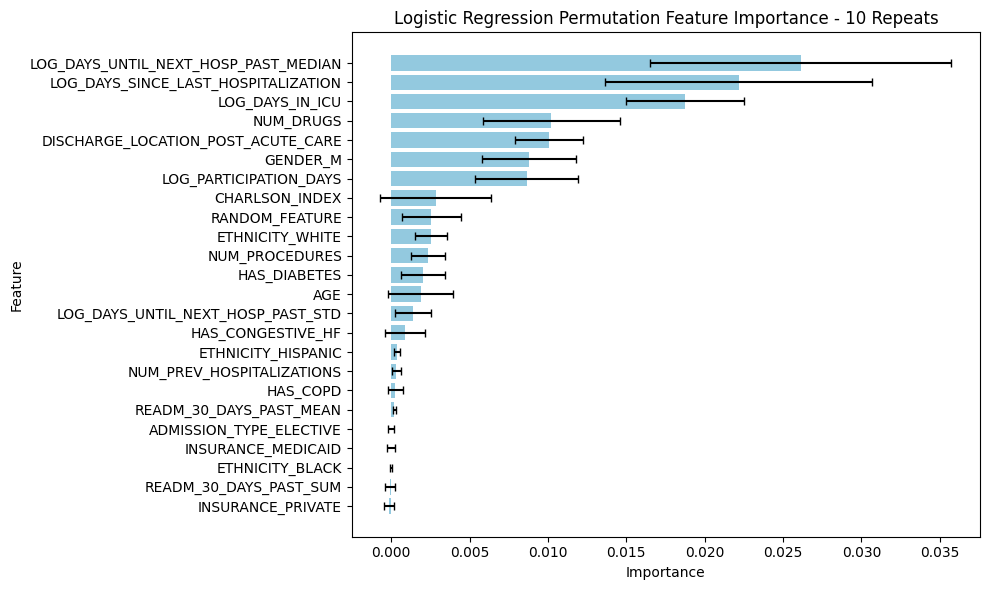

Calculating SHAP values for 1412 samples...


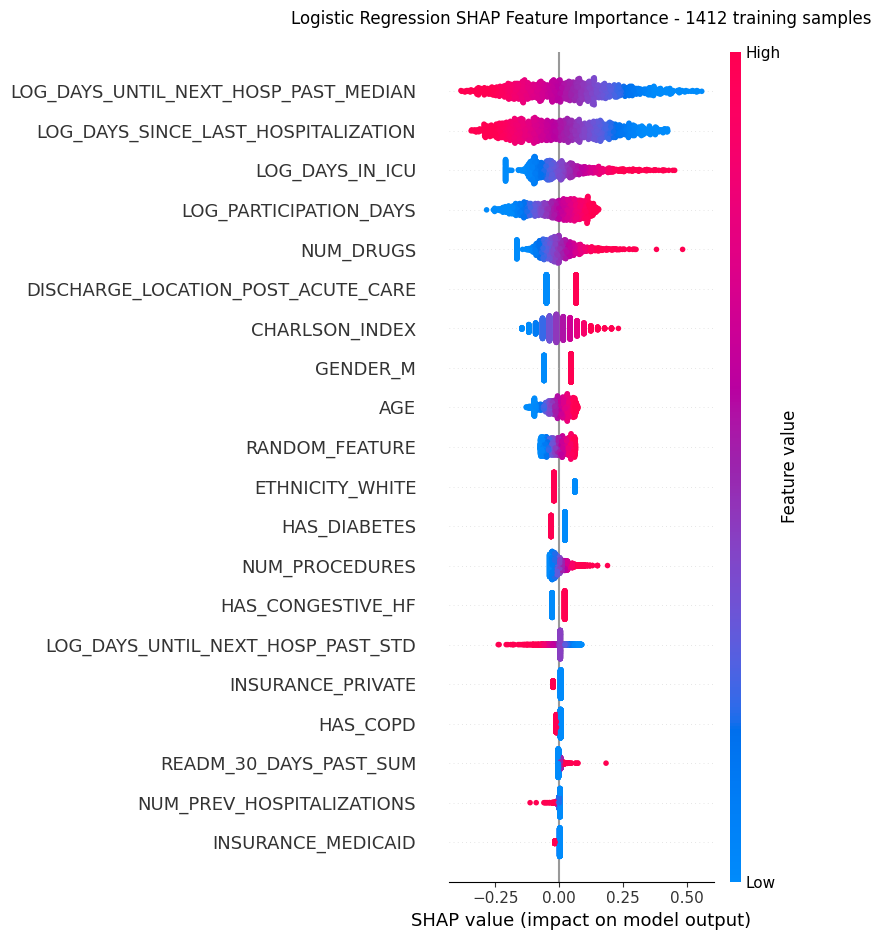

Finished training and evaluation of Logistic Regression.



In [12]:
# ===== Logistic Regression =====
from sklearn.linear_model import LogisticRegression

if "logistic_regression" in models_to_train:
    additional_params: dict = model_config.get("log_reg", {}).get("additional_params", {})
    logreg_model = LogisticRegression(random_state=random_state, **additional_params)

    param_distributions = model_config["logistic_regression"]["param_distributions"]
    param_distributions["C"] = np.logspace(-4, 4, 100)  # 100 values between 1e-4 and 1e4
    rand_search_config = model_config["logistic_regression"]["rand_search_config"]

    y_pred_proba_logreg, y_pred_logreg, eval_results_logreg, cv_search_results_logreg = train_test_classifier(
        logreg_model,
        "Logistic Regression",
        X_train_scaled,
        y_train,
        X_test_scaled,
        y_test,
        param_distributions,
        rand_search_config,
        neptune_run=None,
        verbose=True,
        plot_shap=plot_shap,
        random_state=random_state,
        class_names=class_names,
        show_plots=True,
    )
    y_pred_proba_dict["logreg"], y_pred_dict["logreg"] = y_pred_proba_logreg, y_pred_logreg


In [13]:
from recurrent_health_events_prediction.training.utils import plot_pred_proba_distribution

fig_hist = plot_pred_proba_distribution(y_test, y_pred_proba_logreg, show_plot=False, class_names=class_names_dict)

fig_hist.update_layout(template="plotly_white", title ="Histogram of Predicted Probabilities by True Labels - Logistic Regression")
fig_hist.show()

In [14]:
from recurrent_health_events_prediction.training.utils import plot_calibration_curve

fig = plot_calibration_curve(y_test, y_pred_proba_logreg, show_plot=False, title ="Calibration Curve - Logistic Regression")
fig.show()

## Random Forest


Training Random Forest with hyperparameter search...
Train AUC for best Random Forest:  0.7098268844246484
Best threshold for F1 score in train set: 0.4725 with F1: 0.5090
15 candidates of Random forest trained and validated with cross-validation on 5 folds.
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 3}
Validation Score - Random forest: 0.623 ± 0.044
Random Forest model evaluation:
AUC:  0.6239409445516316
F1 Score: 0.4155
Recall: 0.6484
Accuracy: 0.5297
Precision: 0.3057


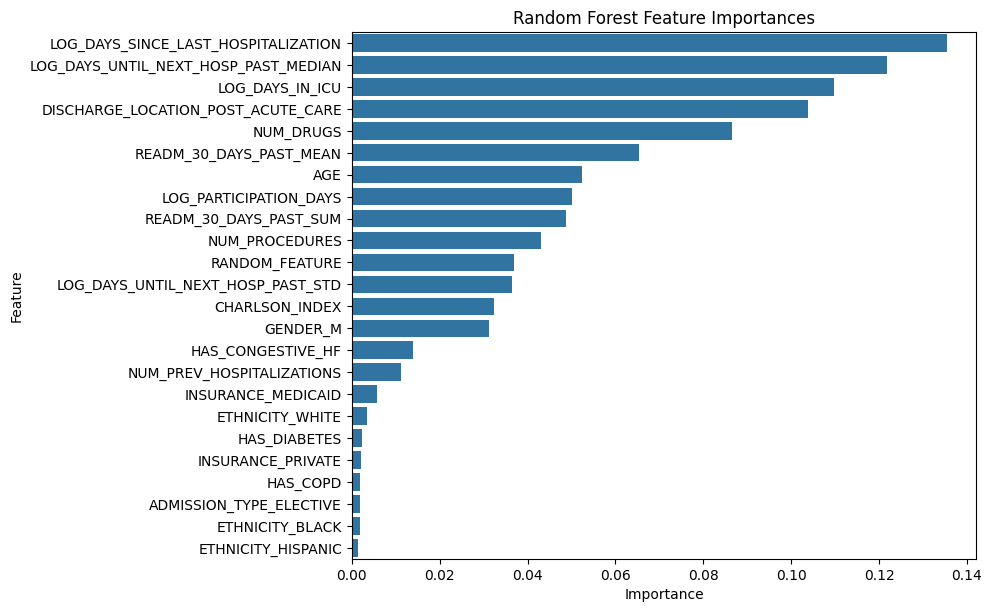

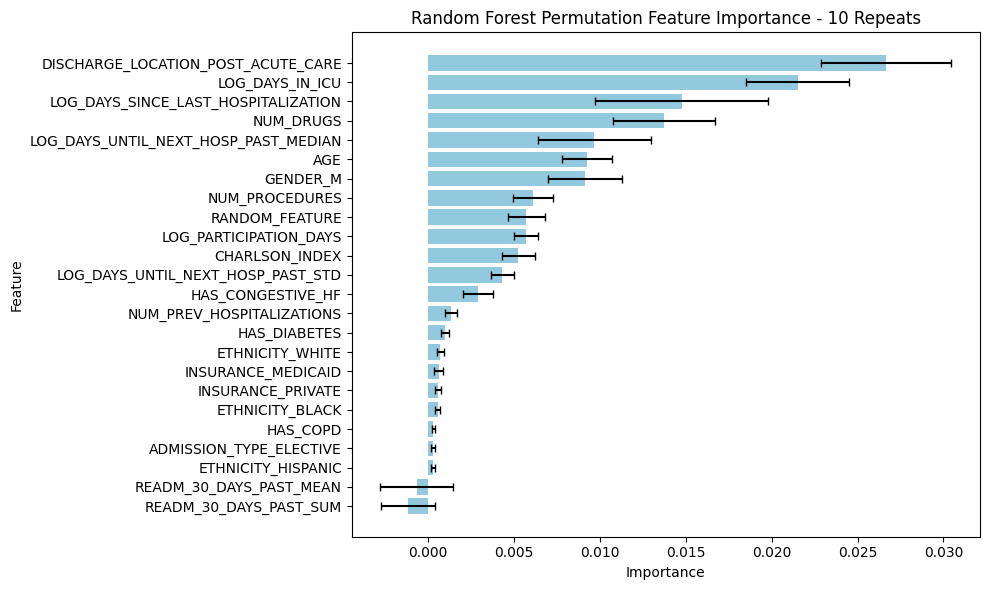

Calculating SHAP values for 1412 samples...


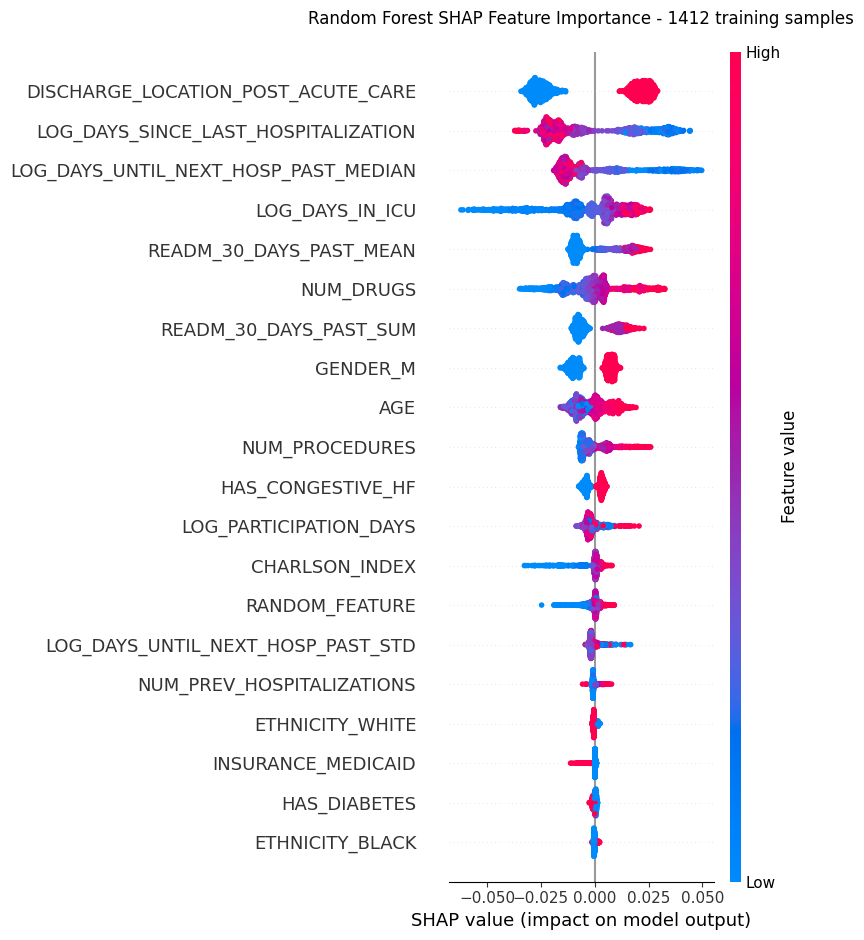

Finished training and evaluation of Random Forest.



In [16]:
# ===== Random Forest =====
from sklearn.ensemble import RandomForestClassifier

if "random_forest" in models_to_train:
    additional_params: dict = model_config.get("random_forest", {}).get("additional_params", {})
    rf_model = RandomForestClassifier(random_state=random_state, **additional_params)

    param_distributions = model_config["random_forest"]["param_distributions"]
    rand_search_config = model_config["random_forest"]["rand_search_config"]

    y_pred_proba_rf, y_pred_rf, eval_results_rf, cv_search_results_rf = train_test_classifier(
        rf_model,
        "Random Forest",
        X_train,
        y_train,
        X_test,
        y_test,
        param_distributions,
        rand_search_config,
        neptune_run=None,
        verbose=True,
        plot_shap=plot_shap,
        random_state=random_state,
        class_names=class_names,
        show_plots=True,
    )
    y_pred_proba_dict["rf"], y_pred_dict["rf"] = y_pred_proba_rf, y_pred_rf


In [17]:
from recurrent_health_events_prediction.training.utils import plot_pred_proba_distribution

fig_hist = plot_pred_proba_distribution(y_test, y_pred_proba_rf, show_plot=False, class_names=class_names_dict)

fig_hist.update_layout(title ="Histogram of Predicted Probabilities by True Labels - Random Forest", height=400)
fig_hist.show()

## LightGBM

In [17]:
# ===== LightGBM =====
from lightgbm import LGBMClassifier

if "lgbm" in models_to_train:
    additional_params: dict = model_config.get("lgbm", {}).get("additional_params", {})
    lgbm = LGBMClassifier(random_state=random_state, **additional_params)

    param_distributions = model_config["lgbm"]["param_distributions"]
    rand_search_config = model_config["lgbm"]["rand_search_config"]

    y_pred_proba_lgbm, y_pred_lgbm, eval_results_lgbm, cv_search_results_lgbm = train_test_classifier(
        lgbm,
        "LightGBM",
        X_train,
        y_train,
        X_test,
        y_test,
        param_distributions,
        rand_search_config,
        neptune_run=None,
        verbose=True,
        plot_shap=plot_shap,
        random_state=random_state,
        class_names=class_names,
    )
    y_pred_proba_dict["lgbm"], y_pred_dict["lgbm"] = y_pred_proba_lgbm, y_pred_lgbm


## Final Results & Comparison

In [18]:
# ===== Save All Predictions =====
from recurrent_health_events_prediction.training.utils_traditional_classifier import save_test_predictions

pred_test_output_filepath = os.path.join(output_dir, "test_predictions.csv")
print("\nSaving test predictions...")
print("Output path for test predictions: ", pred_test_output_filepath)
predictions_df = save_test_predictions(
    out_path=pred_test_output_filepath,
    id_series=test_ids,
    y_true=y_test,
    proba_dict=y_pred_proba_dict,
    pred_dict=y_pred_dict,
    file_format="csv",
)


Saving test predictions...
Output path for test predictions:  /workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/classifier_baselines/test_predictions.csv


In [19]:
predictions_df.head()

,sample_id,y_true,y_pred_proba_logreg,y_pred_proba_rf,y_pred_logreg,y_pred_rf
0,182383,0,0.171881,0.396019,0,0
1,164735,0,0.267028,0.437206,1,0
2,155036,0,0.262746,0.491700,1,1
3,160425,1,0.287764,0.505468,1,1
4,191344,0,0.156857,0.384027,0,0


In [20]:
results_df = pd.DataFrame()

In [21]:
from recurrent_health_events_prediction.training.utils_traditional_classifier import extract_results

if "logistic_regression" in models_to_train:
    dict_logreg_metrics = extract_results(eval_results_logreg, cv_search_results_logreg)
    results_df = pd.concat([results_df, pd.DataFrame([dict_logreg_metrics])], ignore_index=True)

if "random_forest" in models_to_train:
    dict_rf_metrics = extract_results(eval_results_rf, cv_search_results_rf)
    results_df = pd.concat([results_df, pd.DataFrame([dict_rf_metrics])], ignore_index=True)

if "lgbm" in models_to_train:
    dict_lgbm_metrics = extract_results(eval_results_lgbm, cv_search_results_lgbm)
    results_df = pd.concat([results_df, pd.DataFrame([dict_lgbm_metrics])], ignore_index=True)

results_df

,model_name,mean_auc_val,std_auc_val,auc_eval,accuracy_eval,precision_eval,recall_eval,f1_eval
0,Logistic Regression,0.608184,0.042005,0.609261,0.504249,0.290000,0.637363,0.398625
1,Random Forest,0.622714,0.043884,0.623941,0.529745,0.305699,0.648352,0.415493


In [22]:
results_output_filepath = os.path.join(output_dir, "performance_results.csv")
print("\nSaving performance results...")
print("Output path for performance results: ", results_output_filepath)
results_df.to_csv(results_output_filepath, index=False)


Saving performance results...
Output path for performance results:  /workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/classifier_baselines/performance_results.csv
